## Brillouin-Wigner correction of the quasiparticle Hamiltonian

We approach and analyze the structure of the corrections and the properties of these effective Hamiltonians using both the nn-pp quasiparticle and the nn-pp/ np quasiparticle frameworks.

### Get $H_Q$, $H_{RQ}$, $H_{QR}$ and $H_{RR}$ in the nn-pp framework

#### Imports

In [1]:

from NSMFermions.hamiltonian_utils import FermiHubbardHamiltonian
from NSMFermions.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from NSMFermions.qml_models import AdaptVQEFermiHubbard
from NSMFermions.qml_utils.train import Fit
from NSMFermions.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from NSMFermions.utils_quasiparticle_approximation import QuasiParticlesConverter,HardcoreBosonsBasis,QuasiParticlesConverterOnlynnpp


/home/ecosta/miniconda3/envs/annealing-nsm-env/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


#### Hyperparameters of the system, select the nucleus

In [17]:
file_name='data/cki' #select the file with the single particle energies and two-body matrix elements
# initialize the class that handles single particle states
SPS=SingleParticleState(file_name=file_name)
# set the number of particles
nparticles_a=4
nparticles_b=2
# get the dimension of each single particle basis
size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2
# name of the nucleus
title=r'$^{10}$Be'
# load the twobody matrix as a dictionary
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:00<00:00, 12.19it/s]


Compute the NSM Hamiltonian

In [18]:
# initialize the nuclear shell model hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
# set the single particle energy part as an external potential
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
# set the two-body interaction
NSMHamiltonian.get_twobody_interaction_optimized(twobody_matrix)
# compute the matrix representation of the hamiltonian
NSMHamiltonian.get_hamiltonian()
# compute eigenvectors and eigenvalues in the active configuration interaction
eigvals_aci,eigvecs_aci=NSMHamiltonian.get_spectrum(n_states=5)

print(eigvals_aci)

print(NSMHamiltonian.hamiltonian.shape)

Building two-body operator with 1424 terms...


100%|██████████| 1424/1424 [00:00<00:00, 11507.47it/s]

✅ Two-body operator built: shape=(51, 51), nnz=1155
[-39.4534158  -35.74941099 -34.02402475 -30.63939754 -30.51043313]
(51, 51)


Plot the NSM Hamiltonian

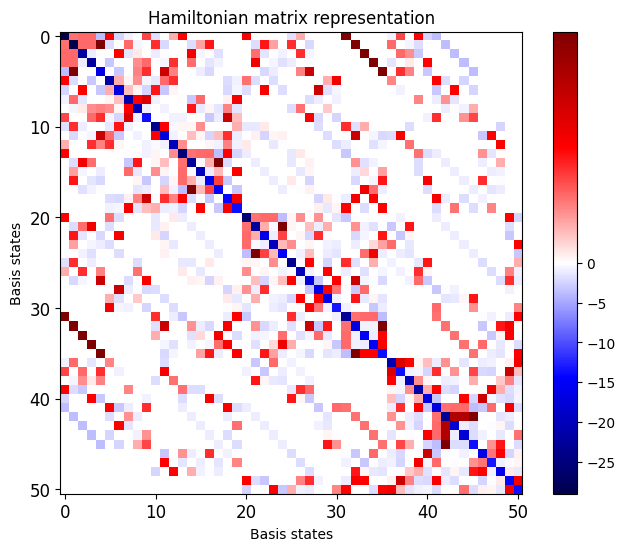

In [19]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = NSMHamiltonian.hamiltonian.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states')
plt.ylabel('Basis states')
plt.title('Hamiltonian matrix representation')
plt.show()

#### Get the Quasiparticle basis and compute the operators

In [20]:
# Initialize the quasiparticle class
QPC=QuasiParticlesConverterOnlynnpp()
# intialize the quasiparticle modes
QPC.initialize_shell(state_encoding=SPS.state_encoding)


# compute the quasiparticle basis and the matrix transformation QP -> ACI
QPC.get_the_basis_matrix_transformation(basis=NSMHamiltonian.basis)
# check the basis reduction
print(QPC.quasiparticle_basis.shape)
print(QPC.rest_basis.shape)



(9, 6)
(42, 12)


Compute the quasiparticle Hamiltonian, the rest Hamiltonian, and the connectors

In [21]:
# particles2quasiparticles: matrix that transforms from the ACI basis to the quasiparticle basis
hamiltonian_qq=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T
hamiltonian_rr=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_qr=QPC.particles2quasiparticles @ NSMHamiltonian.hamiltonian @ QPC.particles2restofstates.T
hamiltonian_rq=QPC.particles2restofstates @ NSMHamiltonian.hamiltonian @ QPC.particles2quasiparticles.T


Plot the Quasiparticle Hamiltonian

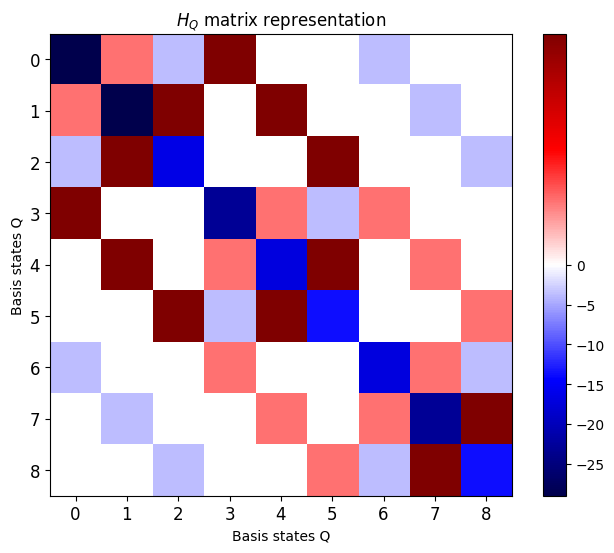

In [22]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(8,6))

# wrap the Hamiltonian in a masked array to hide zeros
H = hamiltonian_qq.toarray()
H_masked = np.ma.masked_where(H == 0, H)
cmap = plt.cm.seismic
cmap.set_bad(color='white')
norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())
### this is done with chatgpt

# Store the image object
im = plt.imshow(H_masked, cmap=cmap, norm=norm)
# Link the colorbar *only to this image*
plt.colorbar(im)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Basis states Q')
plt.ylabel('Basis states Q')
plt.title(r'$H_Q$ matrix representation')
plt.show()

How many two-body operators cannot be represented as a partial quasiparticle interaction? 

In [23]:
print(QPC.couples)

[[0, 3], [1, 2], [4, 5], [6, 9], [7, 8], [10, 11]]


In [24]:
count=0
for key in twobody_matrix.keys():
    a,b,c,d=key
    
    if [min(a,b),max(a,b)] in QPC.couples or [min(c,d),max(c,d)] in QPC.couples:
        continue
    else:
        count+=1
        
print(f'Number of non quasiaparticle two-body matrix elements: {count/len(twobody_matrix)}')

Number of non quasiaparticle two-body matrix elements: 0.9044943820224719


#### Brillouin-Wigner method

Now we adopt the Brillouin Wigner Method for the ground state. We want to explore the convergence and the contribution of each perturbative term.

In [25]:
target_eigenvalue=0
nsteps_iteration=30
# start computing all the correction terms necessary for the Brillouin-Wigner perturbation theory

    
# then we compute the energy corrections
tot_hamiltonian=hamiltonian_qq
values,psiq_order0=eigsh(hamiltonian_qq,k=1)
e=values[0]
approximations=[]

single_term = hamiltonian_rq  # Start with initial term
for i in trange(nsteps_iteration):
    if i > 0:
        diagonal_rr=scipy.sparse.diags(hamiltonian_rr.diagonal())
        ########################################################################## GET THIS
        single_term =diagonal_rr @ single_term  # Efficient update
        ################################################################
        # INSTEAD OF DIRECTLY
        # single_term =hamiltonian_rr @ single_term  # Efficient update
    update=(hamiltonian_qr @ single_term)

    approximations.append(update)  # Store result
    
history_errors_exact=[]
interaction_terms=[]
infidelities=[]
for i in trange(nsteps_iteration):
    
    tot_hamiltonian=hamiltonian_qq
    delta_hamiltonian=0.
    for j in range(i):
        ################################################################### THIS PART WAS MODIFIED TO ADD THE ONLY ONE BODY CORRECTION CONSTRAINS
        # # approximation_onebody=np.zeros_like(hamiltonian_qq.toarray())
        # # for a,base_a in enumerate(QPC.quasiparticle_basis):
        # #     for b,base_b in enumerate(QPC.quasiparticle_basis):
        # #         if np.abs(base_a-base_b).sum()<=2:
        # #             approximation_onebody[a,b]=approximations[j][a,b]
        # # delta_hamiltonian=delta_hamiltonian+approximation_onebody/e**(j+1)
        ###################################################################            
        # INSTEAD OF DIRECTLY
        delta_hamiltonian=delta_hamiltonian+approximations[j]/e**(j+1)
    interaction_terms.append(delta_hamiltonian)
    values,psiq_orderi=eigsh(hamiltonian_qq+delta_hamiltonian,k=1)
    e=values[0]
    fidelity=np.abs(np.vdot(psiq_order0,psiq_orderi))**2
    infidelities.append(1-fidelity)
    print(e)
    print(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]),'index=',i)
    history_errors_exact.append(np.abs((e-eigvals_aci[target_eigenvalue])/eigvals_aci[target_eigenvalue]))

100%|██████████| 30/30 [00:00<00:00, 536.31it/s]

-34.81247367924347
0.11763093321420848 index= 0
-38.444228454811515
0.025579213430115832 index= 1
-39.749777238566395
0.00751168015530526 index= 2
-40.27829834927832
0.020907760064258415 index= 3
-40.515851446974004
0.02692886350715421 index= 4
-40.62911027226927
0.029799561088194735 index= 5
-40.685816772732636
0.031236863773306117 index= 6
-40.71516952191382
0.03198084876389422 index= 7
-40.73078716625237
0.032376699009624185 index= 8
-40.73927010769753
0.03259171059413639 index= 9
-40.743956903743346
0.03271050375693392 index= 10
-40.7465816447769
0.03277703135614084 index= 11
-40.74806829462007
0.032814712500170935 index= 12
-40.74891827592773
0.032836256422046045 index= 13
-40.74940816467619
0.032848673312663806 index= 14
-40.74969247309162
0.032855879492653034 index= 15
-40.749858477626674
0.03286008710134028 index= 16
-40.749955929451744
0.03286255714919542 index= 17
-40.750013415351624
0.032864014206809254 index= 18
-40.75004747460751
0.032864877484555924 index= 19
-40.75006773

#### Convergence with respect to the Energy of the ACI hamiltonian and discrepancy with respect to the initial fidelity of $H_Q$

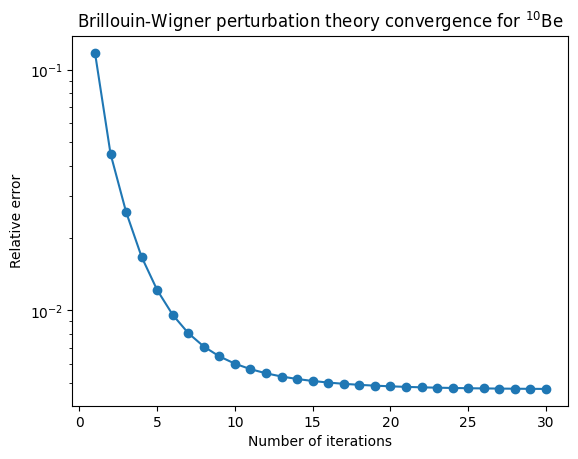

In [124]:
# here we plot the convergence of the Brillouin-Wigner perturbation theory
plt.plot(range(1,nsteps_iteration+1),history_errors_exact,'-o')
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Relative error')
plt.title(f'Brillouin-Wigner perturbation theory convergence for {title}')
plt.show()

How the state changes to get better accuracies in the ground state energy. We should expect a large change in the structure of the GS state, since the energy gets extremelly good results. However what we get is a small deviation in the structure of the Wavefunction and a large discrepancy in the structure of the Hamiltonian.

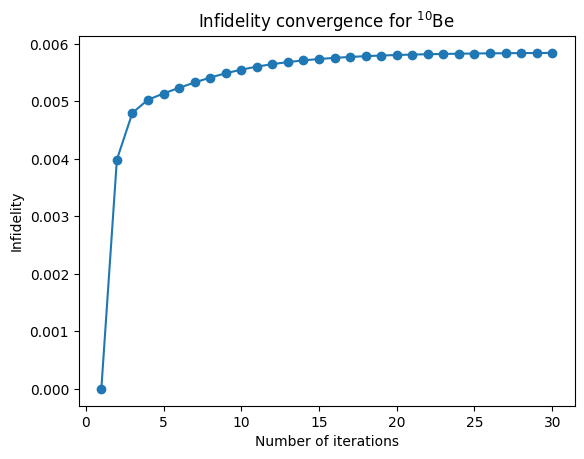

In [125]:
plt.plot(range(1,nsteps_iteration+1),infidelities,'-o')
plt.xlabel('Number of iterations')
plt.ylabel('Infidelity')
plt.title(f'Infidelity convergence for {title}')
plt.show()

Going into this direction, we can compute the expectation value of $\ket{\Psi_{Q0}}$ with respect to the $H_Q^{(N)}$ to get how different is the energy estimation

#### Investigate the structure and the coefficients of the $\Delta H_Q$

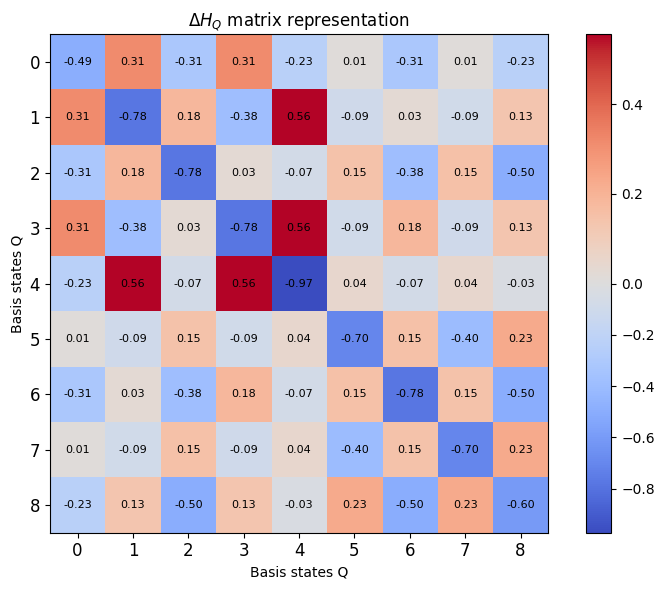

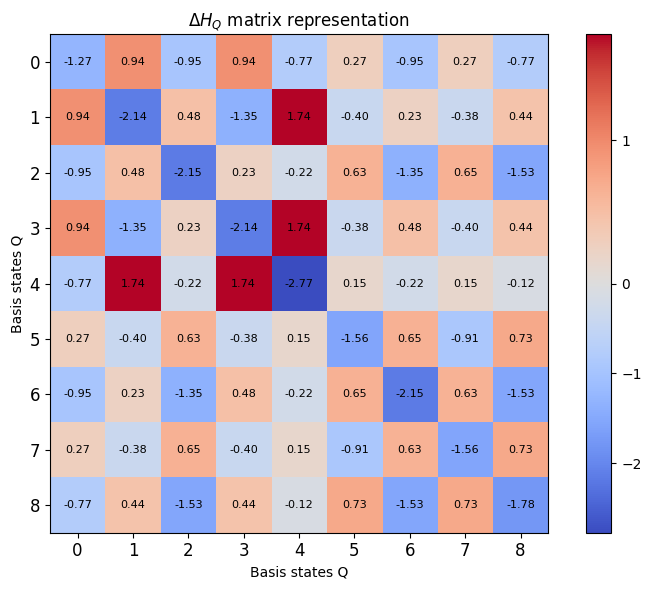

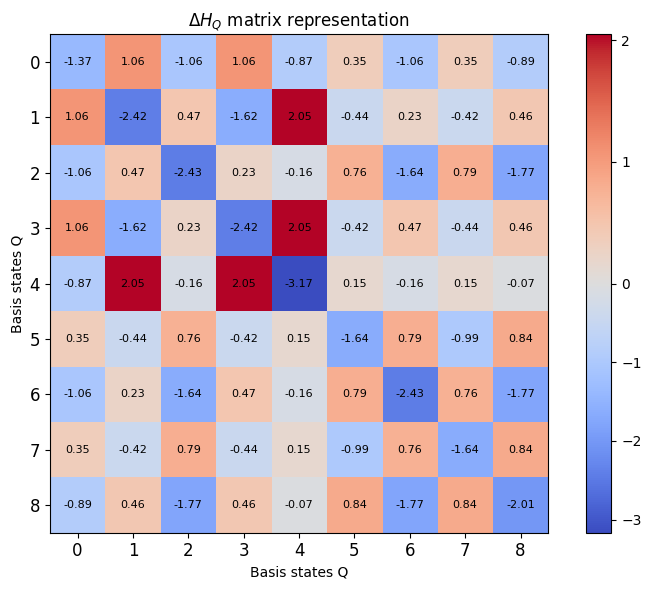

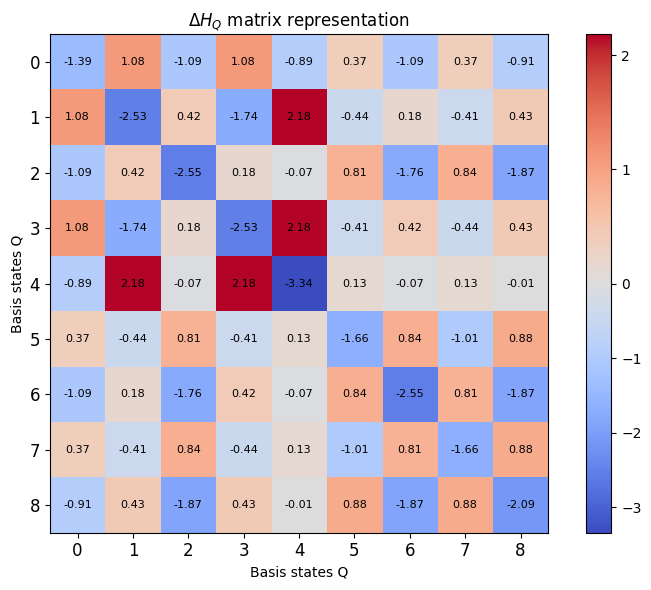

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

for idx,delta_hamiltonian in enumerate(interaction_terms[1:]):
    
    if idx % 5 ==0:
        plt.figure(figsize=(8,6))

        # Hamiltonian as array and masked array
        H = delta_hamiltonian.toarray()
        H_masked = np.ma.masked_where(H == 0, H)

        # colormap + normalization
        cmap = plt.cm.coolwarm
        cmap.set_bad(color='white')
        norm = TwoSlopeNorm(vmin=H.min(), vcenter=0, vmax=H.max())

        # plot
        im = plt.imshow(H_masked, cmap=cmap, norm=norm)

        # single colorbar
        plt.colorbar(im)

        # --- Add numbers on top of cells ---
        nrows, ncols = H.shape
        for i in range(nrows):
            for j in range(ncols):
                if H[i, j] != 0:   # skip zeros
                    plt.text(
                        j, i, f"{H[i, j]:.2f}",        # number with 2 decimals
                        ha="center", va="center",
                        color="black", fontsize=8      # adjust readability
                    )

        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.xlabel('Basis states Q')
        plt.ylabel('Basis states Q')
        plt.title(r'$\Delta H_Q$ matrix representation')

        plt.tight_layout()
        plt.show()



Ok, but what if we get only diagonal corrections ??

In [93]:
# we isolate the diagonal corrections only
diagonal_corrections=interaction_terms[-1].diagonal()
diagonal_corrections_matrix=np.diag(diagonal_corrections)

effective_hamiltonian_only_diagonal_corrections=hamiltonian_qq+diagonal_corrections_matrix
values,psiq_orderi=eigsh(effective_hamiltonian_only_diagonal_corrections,k=1)
e=values[0]
print(e)    
print(diagonal_corrections.shape)

-66.80787397812529
(9,)


Ok, and what if you add also one-flip corrections?

In [94]:
only_one_flip_corrections=np.zeros_like(interaction_terms[-1].toarray())
for a,base_a in enumerate(QPC.quasiparticle_basis):
    for b,base_b in enumerate(QPC.quasiparticle_basis):
        if np.abs(base_a-base_b).sum()<=2:
            only_one_flip_corrections[a,b]=interaction_terms[-1][a,b]


effective_hamiltonian_one_flip_corrections=hamiltonian_qq+only_one_flip_corrections
values,psiq_orderi=eigsh(effective_hamiltonian_one_flip_corrections,k=1)
e=values[0]
print(e)

-69.53292145215697


#### Count the N-Quasiparticle body terms

In [ ]:
count_0=0
count_1=0
count_2=0
for a,base_a in enumerate(QPC.quasiparticle_basis):
    for b,base_b in enumerate(QPC.quasiparticle_basis):
        if np.abs(base_a-base_b).sum()==2 and interaction_terms[-1][a,b]!=0:
            count_1+=1
            print(base_a,base_b,np.abs(base_a-base_b).sum())
        if np.abs(base_a-base_b).sum()==0 and interaction_terms[-1][a,b]!=0:
            count_0+=1
            
        if np.abs(base_a-base_b).sum()==4 and interaction_terms[-1][a,b]!=0:
            print(base_a,base_b,np.abs(base_a-base_b).sum())
            count_2+=1

print(count_0,count_1//2,count_2//2)